## Violations Search Tau

> Written by Jess Breda September 2023

For this notebook, I am working based on the to-dos from 2023-08-29 meeting and previous notebook `2023_08_violations_feature_analysis`/

The goals for this NB are

1. Update & test code to only apply exp filter to a session at a time

2. Update code to normalize all together before train test split. This might mean changing the order in generate_design_matrix. 
    * Or just a function that takes a list of dfs and finds the max value and normalize them by it?
    * Or just pass in the generated design matrix into train test split

3. Iterate over a finer grid of taus and sigmas

sigmas = 0.01, 0.1, 0.2, 0.5, 1, 1.5, 2, 2.5, 3, 5

taus = 1, 2, 3, 5, 10, 12, 15, 17, 20, 25, 30

In [49]:
import pathlib
import platform
import sys
[
    sys.path.append(str(folder))
    for folder in pathlib.Path("../src/").iterdir()
    if folder.is_dir()
]
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_context("talk")

from sklearn.model_selection import train_test_split

from generate_design_matrix import *
from get_rat_data import *
from multiclass_logistic_regression import *
from method_validation import plot_kernel_validation

MODE = "local"

# settings
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Apply exp filter on session by session basis

In [16]:
# Example usage
df = pd.DataFrame(
    {
        "session": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3],
        "violation": np.random.randint(0, 2, 22),
    }
)
tau = 5
filter_obj = ExpFilter(tau=tau, column="violation")
filter_obj.apply_filter_to_dataframe(df)

Exp filter added for session 1 | Column: violation, Tau: 5
Exp filter added for session 2 | Column: violation, Tau: 5
Exp filter added for session 3 | Column: violation, Tau: 5


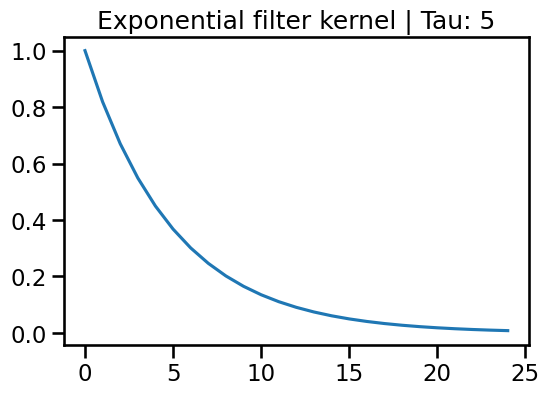

In [17]:
filter_obj.plot_kernel()

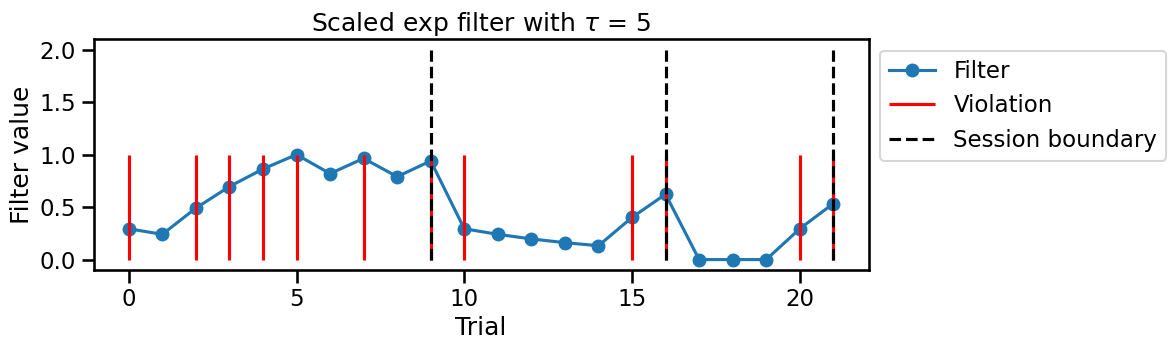

In [18]:
plot_kernel_validation(df, f"violation_exp_{tau}")

In [50]:
ANIMAL_ID = "W065"
df = get_rat_viol_data(animal_ids=ANIMAL_ID)

returning data for W065


In [87]:
params = {
    "animals": ["W065"],
    "sigmas": [0, 0.5, 1, 1.5, 3, 5, 10, 20],
    "taus": [None, 1, 2, 3, 5, 7, 9, 12, 15, 18, 20, 25, 30],
}
params = generate_model_names(params)

In [88]:
fit_dfs = []


df = get_rat_viol_data(animal_ids=animals)
for animal in params["animals"]:
    if df.animal_id.nunique() > 1:
        animal_df = df.query("animal_id == @animal")

    dmg = DesignMatrixGenerator(verbose=False)
    dmg.get_train_test_sessions(animal_df, test_size=0.25, random_state=55)

    for sigma in params["sigmas"]:
        for idx, tau in enumerate(params["taus"]):
            X, Y = dmg.generate_design_matrix(df, tau=tau, return_labels=True)

            X_train, X_test, Y_train, Y_test = dmg.apply_session_train_test_split(X, Y)

            W_fit = fit_multiclass(X_train, Y_train, sigma=sigma, disp=True)

            nll = multiclass_logistic_cost(W_fit, X_test.to_numpy(), Y_test, sigma=None)

            # Create a DataFrame for this iteration
            iter_df = pd.DataFrame(
                {
                    "animal_id": [animal],
                    "model_name": [params["names"][idx]],
                    "nll": [nll],
                    "sigma": [sigma],
                    "features": [list(X_train.columns)],
                    "weights": [W_fit.tolist()],  # Convert numpy array to list
                }
            )

            # Append the DataFrame to the list
            fit_dfs.append(iter_df)

    # Concatenate all the DataFrames in the list
    fitting_info_df = pd.concat(fit_dfs, ignore_index=True)

returning data for ['W065']
Optimization terminated successfully.
         Current function value: 36900.726166
         Iterations: 22
         Function evaluations: 32
         Gradient evaluations: 32
         Current function value: 15715.746497
         Iterations: 64
         Function evaluations: 75
         Gradient evaluations: 75
         Current function value: 20604.214671
         Iterations: 37
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 24464.988213
         Iterations: 32
         Function evaluations: 65
         Gradient evaluations: 64
         Current function value: 28010.139741
         Iterations: 27
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 29728.187617
         Iterations: 28
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated succes

In [89]:
def find_best_sigma(fitting_info_df):
    # Group by 'model_name' and find the row with minimum 'nll' for each group
    idx_best_sigma = fitting_info_df.groupby("model_name")["nll"].idxmin()

    # Use these indices to find the corresponding best 'sigma' values
    best_sigma_df = fitting_info_df.loc[idx_best_sigma][["model_name", "sigma", "nll"]]

    return best_sigma_df


best_sigma_df = find_best_sigma(fitting_info_df)


def plot_best_fit(best_sigma_df):
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.barplot(
        x="model_name", y="nll", data=best_sigma_df, ax=ax, order=params["names"]
    )
    plt.xticks(rotation=90)

    for p, sigma in zip(ax.patches, best_sigma_df["sigma"]):
        ax.annotate(
            f"σ={sigma}",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="baseline",
            xytext=(0, 10),
            textcoords="offset points",
        )
    sns.despine()

    ax.set(
        ylabel="Test Negative Log Likelihood",
        xlabel="Model",
    )

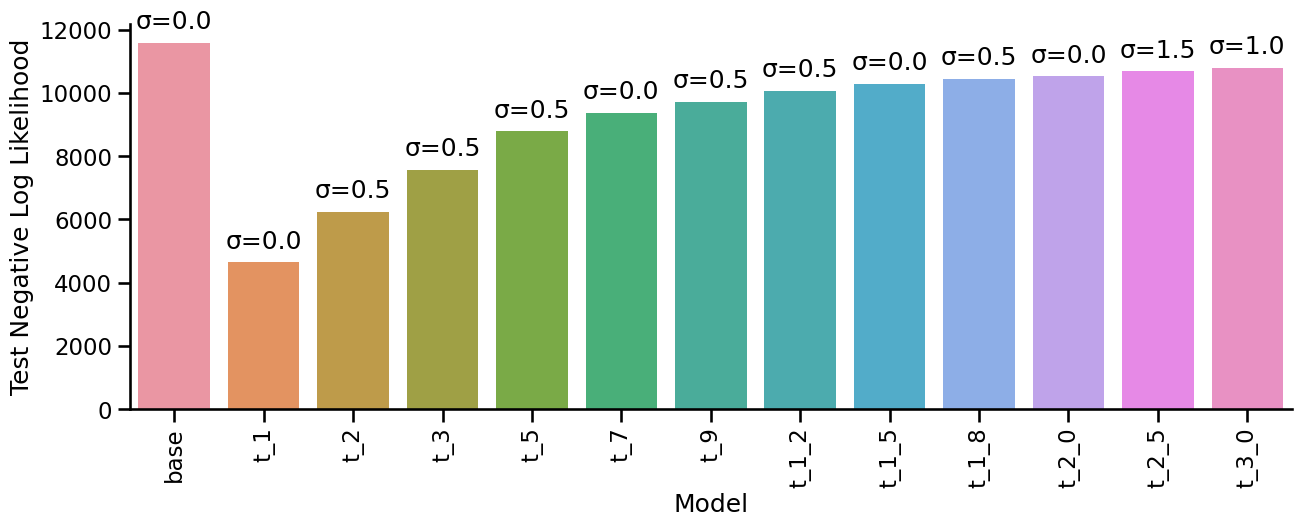

In [90]:
plot_best_fit(best_sigma_df)

In [91]:
def plot_class_weights(feature_names, W_fit, title=""):
    """
    Plot the weights for each feature and class as bar charts.

    Parameters:
    feature_names: list (D)
         column names from design matrix that related
         to features in W_fit
    W_fit : np.ndarray (D x C)
        weights obtained after optimization (D x C)
    title : str (default: "")
        title for the plot
    """

    # Extract shape details
    D, C = W_fit.shape
    classes = ["L", "R", "V"]

    # Prepare data for Seaborn
    weight_data = []
    for c in range(C):
        for d in range(D):
            weight_data.append(
                {
                    "Weight": W_fit[d, c],
                    "Feature": feature_names[d],
                    "Class": classes[c],
                }
            )

    df_weights = pd.DataFrame(weight_data)

    # Plot using Seaborn
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.axhline(y=0, color="black")
    sns.barplot(x="Feature", y="Weight", hue="Class", data=df_weights, ax=ax)
    plt.xticks(rotation=90)
    plt.legend(loc="upper left")
    plt.title(title)

    return None


def plot_class_weights_from_df(fitting_info_df, model_name):
    row = fitting_info_df.loc[fitting_info_df["model_name"] == model_name].iloc[0]
    features = row["features"]
    weights = np.array(row["weights"])
    plot_class_weights(features, weights, title=model_name)

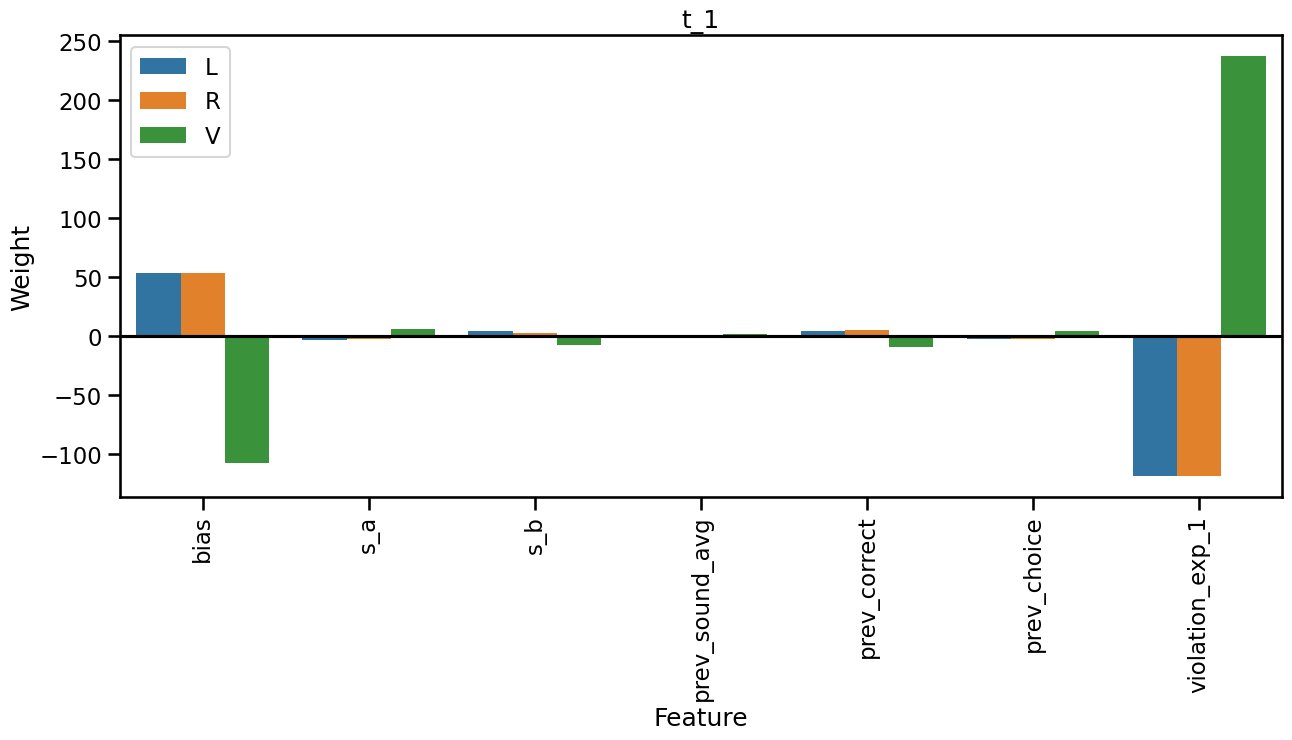

In [92]:
plot_class_weights_from_df(fitting_info_df, "t_1")

This looks a little weird- why is viol_exp_1 such a large weight? Are things not being properly normalized? Need to do some investigation with violation_exp_1 to see what the kernel looks like.

Could think about putting some of the plotting functions above into a separate file. 

Also could involve some polishing where FitMutliClassLR class could be made with .fit, .eval, .store .plot(?) functions. 
